In [3]:
from datetime import datetime
from lithops import Storage
from lithops.multiprocessing import Pool
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import mtranslate
import json
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BUCKET="2sdpractica"

In [4]:
def get_auth():
    auth = tweepy.OAuthHandler("Zi1TsHUNuaxZSfKBKGaxJXvMn", "YW3YUZpbdTYSsl23fGKaEBNz1OyPpdPwQnsH9h6MYWitslQIR1")
    auth.set_access_token("1059931089999945729-rqs5uhDmTXgZpCtJkhK1uE4IOHfs0x", "gyk3WerX8tjEEFox4UNfu68X0ALicUnvICq4RiG5B65lj")
    return auth

def tweepy_scan(word):
    global BUCKET
   
    auth = get_auth()
    api = tweepy.API(auth, wait_on_rate_limit=True)
   
    analyzer = SentimentIntensityAnalyzer()
   
    datos = {
        "Mensaje": [],
        "url": [],
        "sentiment": [],
        "date": [],
        "local":[],
    }
    
    for status in tweepy.Cursor(api.search, q=word, lang="es", tweet_mode="extended").items(250): #numberOftwets
        datos["Mensaje"].append(status.full_text)
        datos["url"].append("https://twitter.com/twitter/statuses/"+str(status.id)+",")
        datos["date"].append(status.created_at.strftime("%m/%d/%Y %H:%M:%S"))
        datos["local"].append(str(status.user.location))
      

    for text in datos["Mensaje"]:
        string_twi = mtranslate.translate(str(text),"en", "auto")
        datos["sentiment"].append(str(analyzer.polarity_scores(string_twi)['compound']))

    now = datetime.now()
    data = now.strftime("%m/%d/%Y")

    storage = Storage()  
    storage.put_object(BUCKET,data+"-"+word+".json",json.dumps(datos))

In [5]:
    def datos_twitter(word):
        global BUCKET

        datos_grafi = {
            "sent_pos" : 0,
            "sent_neg" : 0,
            "mitjana": 0.0,
            "sent_hist": [],
            "word": word,
            "location_count": { 
            }
        }

        now = datetime.now()
        data = now.strftime("%m/%d/%Y")
        key= data+"-"+ word +'.json'

        storage = Storage()
        json_read = storage.get_object(BUCKET,key)
        data = json.loads(json_read)

        mitjana = 0
        for sent in data["sentiment"]:
            sent = float(sent)
            if sent >= 0:
                datos_grafi["sent_pos"] += 1
            else:
                datos_grafi["sent_neg"] += 1
            
            mitjana += sent
            datos_grafi["sent_hist"].append(round(sent, 1)) 
            
            datos_grafi["mitjana"] = (mitjana/len(data["sentiment"]))
        
        for loc in data["local"]:
            if loc in datos_grafi["location_count"]:
                datos_grafi["location_count"][loc] += 1
            else:
                datos_grafi["location_count"][loc] = 1

        return datos_grafi


In [6]:
def grafic_sentiment(datos):
   
    plt.figure(figsize=(6,8))
    eje_x = ['Positiu', 'Negatiu']
    eje_y = [datos["sent_pos"], datos["sent_neg"]]
    
    ## Creamos Gráfica
    plt.bar(eje_x, eje_y, color = ["blue", "red"], width=0.60)

    ## Legenda en el eje y
    plt.ylabel("Nº Tweets")
    
    ## Título de Gráfica
    plt.title("Sentimiento de los Tweets sobre: " + datos["word"])
    
    ## Mostramos Gráfica
    plt.show()

In [7]:
def grafic_historiaSentiment(datos):
      
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=datos["sent_hist"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel("Sentiment : (-1) Negative - (1) Positive")
    plt.ylabel("Nº Tweets")
    plt.title("Densitat de sentiment sobre: " + datos["word"])
    
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    plt.show()

In [8]:
def grafic_localitzacio(datos):
    keys= []
    values = []
    datos["location_count"].pop('')
    for key in datos["location_count"]:
        val = datos["location_count"][key]
        if val > 1:
            keys.append(key)
            values.append(val)

    plt.figure(figsize=(10,12))
    plt.title("Localització dels tweets ( > 1):" + datos["word"])
    plt.xlabel("Localitzacions")
    plt.ylabel("Nº Tweets") 
    plt.bar(keys,values, color = ["green"])
    plt.xticks(rotation=90)
    plt.show()

In [9]:
def grafic_globalSentiment(datos):

    ind = np.arange(2)
    plt.figure(figsize=(6,8))
    dat0 = (datos[0]["sent_pos"], datos[0]["sent_neg"])
    dat1 = (datos[1]["sent_pos"], datos[1]["sent_neg"])
    dat2 = (datos[2]["sent_pos"], datos[2]["sent_neg"])
    dat3 = (datos[3]["sent_pos"], datos[3]["sent_neg"])
    dat4 = (datos[4]["sent_pos"], datos[4]["sent_neg"])
    dat5 = (datos[5]["sent_pos"], datos[5]["sent_neg"])
    
    width=0.60
    plt.bar(ind, dat0, width, color='brown')
    plt.bar(ind, dat1, width, bottom=dat0, color='red')
    plt.bar(ind, dat2, width, bottom=dat1, color='green')
    plt.bar(ind, dat3, width, bottom=dat2, color='blue')
    plt.bar(ind, dat4, width, bottom=dat3, color='grey')
    plt.bar(ind, dat5, width, bottom=dat4, color='magenta')

    plt.ylabel('Nº Tweets')
    plt.xlabel("Sentiment")
    plt.title('Resum general del sentiment')
    plt.legend(labels=[ "covid", "moderna", "pfizer", "astrazeneca","sputnik v", "janssen"])
    plt.xticks(ind, ('Positiu', 'Negatiu'))
    plt.show()

In [10]:
with Pool() as pool:
        pool.map( tweepy_scan, [ "covid", "moderna", "pfizer", "astrazeneca", "sputnik v", "janssen"])
        datos = pool.map( datos_twitter, [ "covid", "moderna", "pfizer", "astrazeneca","sputnik v", "janssen"])

2021-06-15 20:35:02,916 [INFO] lithops.config -- Lithops v2.3.3
2021-06-15 20:35:02,920 [INFO] lithops.storage.backends.localhost.localhost -- Localhost Storage client created
2021-06-15 20:35:02,921 [INFO] lithops.localhost.localhost -- Localhost compute client created
2021-06-15 20:35:02,921 [INFO] lithops.executors -- Localhost Executor created with ID: 69bf44-0
2021-06-15 20:35:02,922 [INFO] lithops.invokers -- ExecutorID 69bf44-0 | JobID M000 - Selected Runtime: python.exe 
2021-06-15 20:35:02,927 [INFO] lithops.job.job -- ExecutorID 69bf44-0 | JobID M000 - Uploading function and data - Total: 2.3KiB
2021-06-15 20:35:02,930 [INFO] lithops.invokers -- ExecutorID 69bf44-0 | JobID M000 - Starting function invocation: None() - Total: 6 activations
2021-06-15 20:35:02,941 [INFO] lithops.invokers -- ExecutorID 69bf44-0 | JobID M000 - View execution logs at C:\Users\Victor\AppData\Local\Temp\lithops\logs\69bf44-0-M000.log
2021-06-15 20:35:02,943 [INFO] lithops.wait -- ExecutorID 69bf44-0

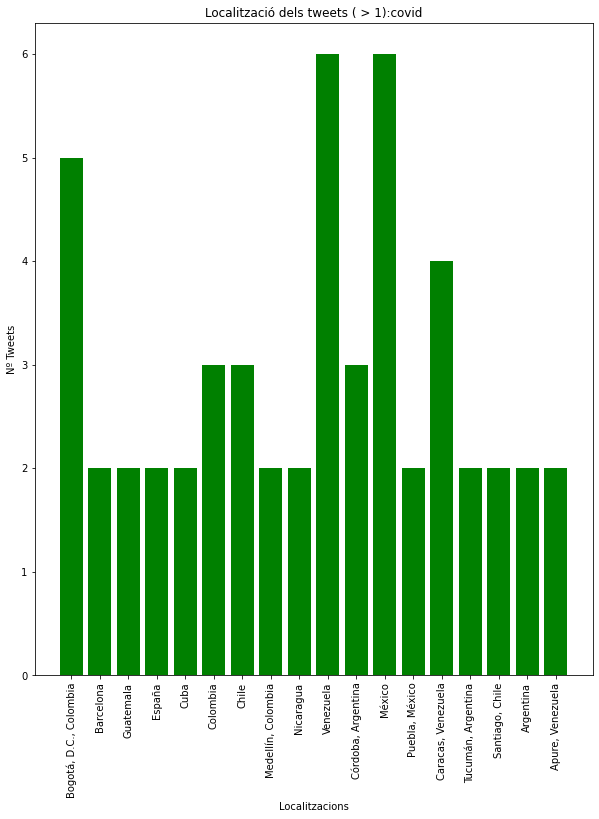

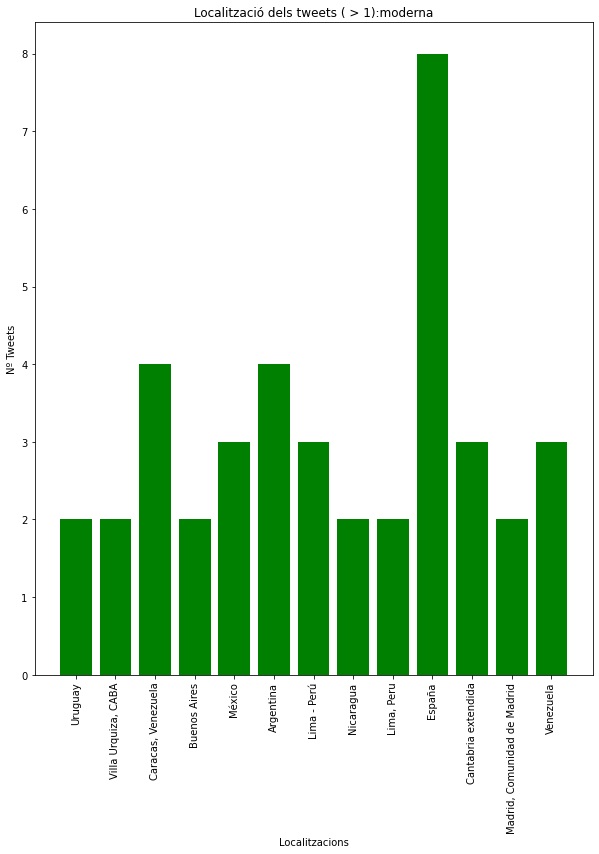

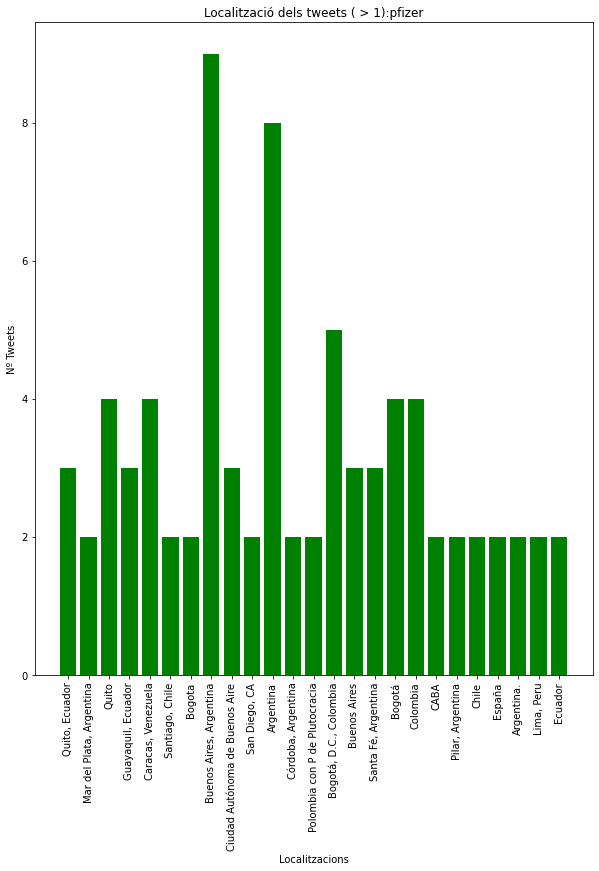

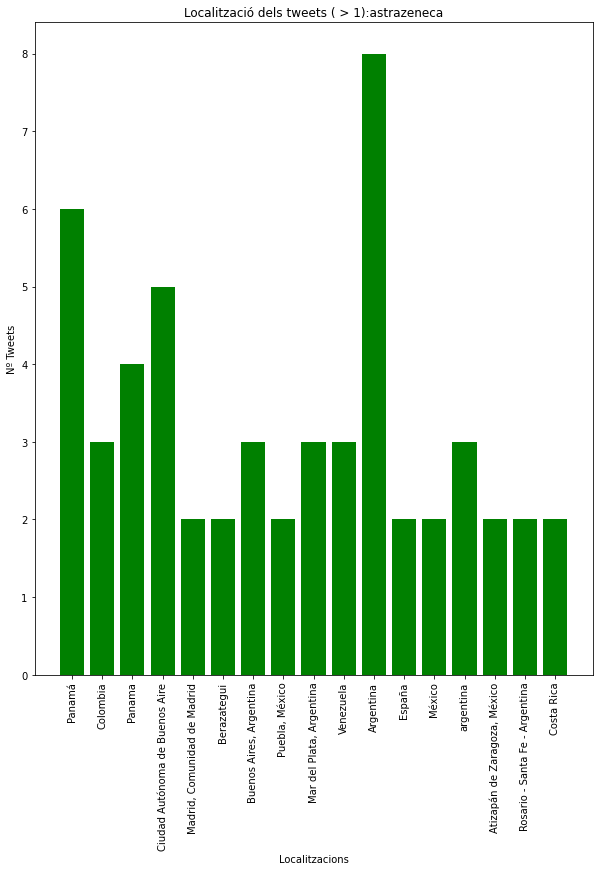

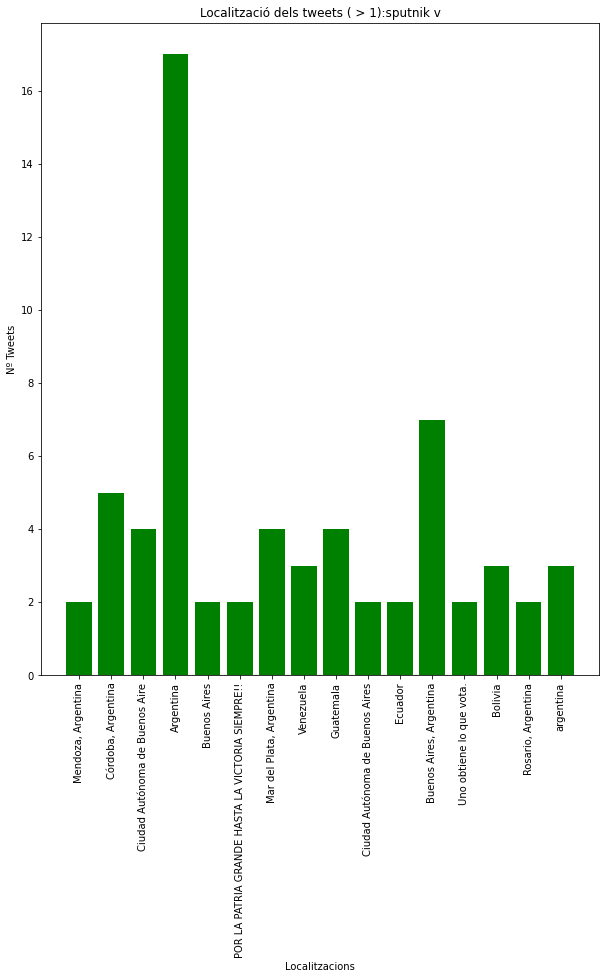

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128153 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarn

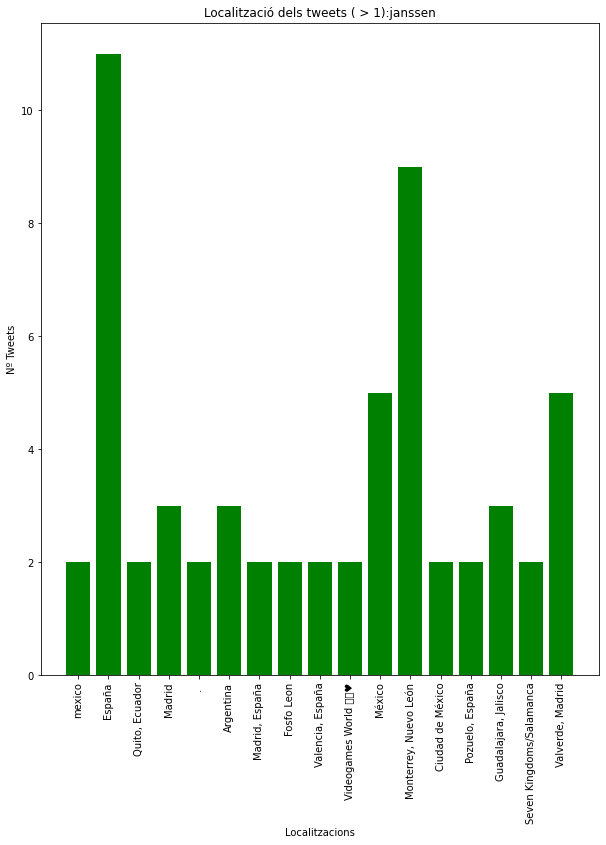

In [11]:
grafic_localitzacio(datos[0])
grafic_localitzacio(datos[1])
grafic_localitzacio(datos[2])
grafic_localitzacio(datos[3])
grafic_localitzacio(datos[4])
grafic_localitzacio(datos[5])

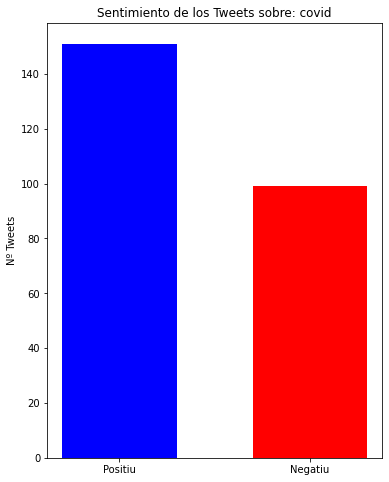

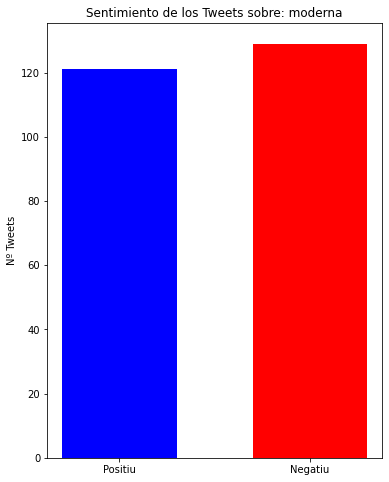

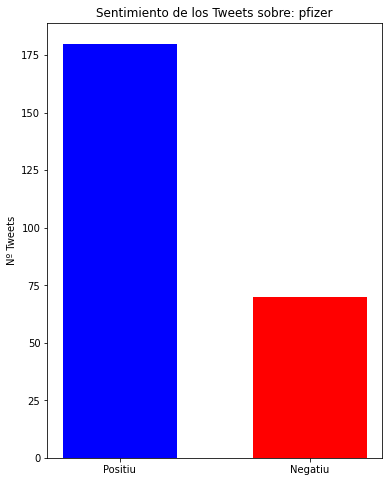

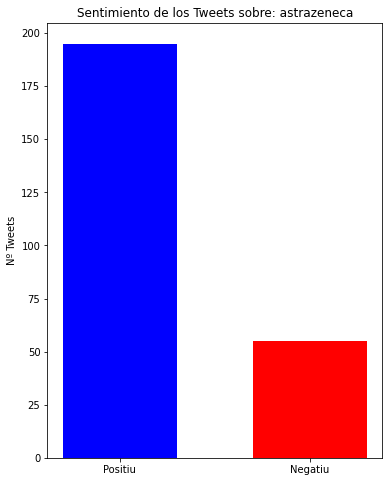

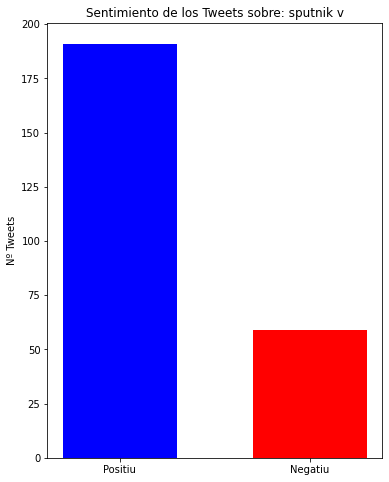

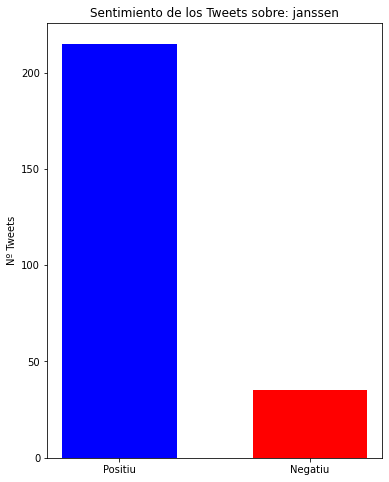

In [12]:
grafic_sentiment(datos[0])
grafic_sentiment(datos[1])
grafic_sentiment(datos[2])
grafic_sentiment(datos[3])
grafic_sentiment(datos[4])
grafic_sentiment(datos[5])

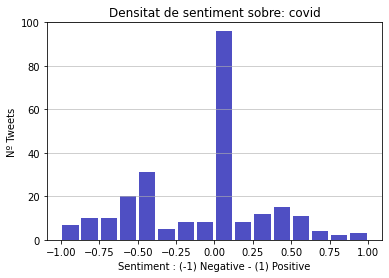

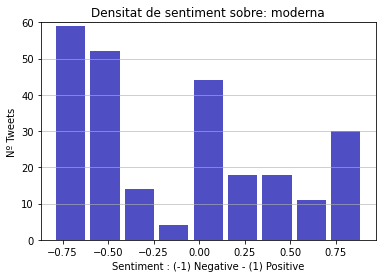

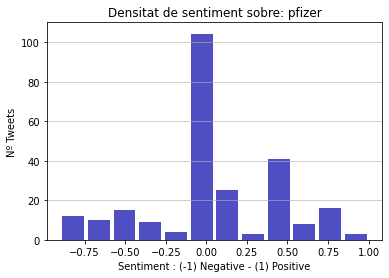

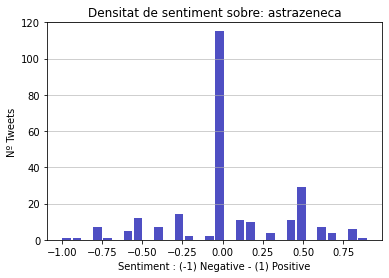

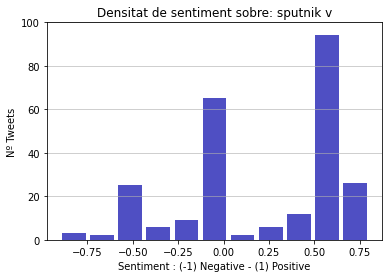

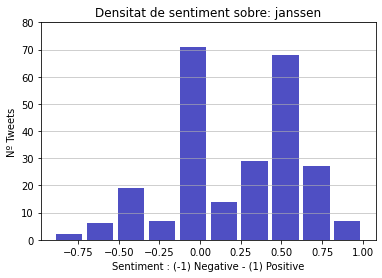

In [13]:
grafic_historiaSentiment(datos[0])
grafic_historiaSentiment(datos[1])
grafic_historiaSentiment(datos[2])
grafic_historiaSentiment(datos[3])
grafic_historiaSentiment(datos[4])
grafic_historiaSentiment(datos[5])

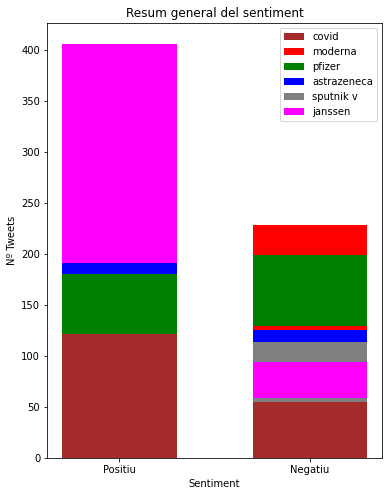

In [14]:
 grafic_globalSentiment(datos)